In [1]:
%matplotlib inline
import bnpy
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import random
import os
import pickle
import matplotlib.pyplot as plt
import gzip

from subprocess import Popen, PIPE
from threading import Timer
from scipy.stats import iqr, percentileofscore
from statsmodels import robust
from sklearn.metrics import roc_curve, auc

date = str(datetime.date.today())

In [2]:
pth = 'data/TCGA-glioblastoma-multiforme-log2TPM1.tsv'

nbl = pd.read_csv(pth, sep='\t', index_col=0)

In [3]:
pth = 'data/h.all.v6.2.symbols.gmt'

gss = {}
gss_mean_mean = {}
gss_median_mean = {}
gss_mean_mad = {}
with open(pth) as f:
    for line in f:
        fields = line.strip().split()
        gss[fields[0]] = fields[2:]
        _mean = nbl.reindex(fields[2:]).dropna().mean(axis=1).mean()
        gss_mean_mean[fields[0]] = _mean

In [4]:
mformat = {'hydra': 'Hydra',
           'ssgsea': 'ssGSEA',
           'gsva': 'GSVA'}

mcolor = {'hydra': '#003050',
          'ssgsea': '#7096a0',
          'gsva': '#b0b7a7'}

In [5]:
import uuid
import numpy as np


def fit(xdata):
    #data = data.apply(lambda x: x - x.mean(), axis=1)
    #data = data.T.values

    #xdata = bnpy.data.XData(data)

    gamma = 5.0
    sF = 2.0
    K = 2

    hmodel, info_dict = bnpy.run(
        xdata, 'DPMixtureModel', 'Gauss', 'memoVB',
        output_path=('/tmp/%s/' % uuid.uuid4() +
            'trymoves-K=%d-gamma=%s-ECovMat=%s*eye-moves=merge,shuffle/' % (
                K, gamma, sF)),
        nLap=1000, nTask=1, nBatch=1,
        gamma0=gamma, sF=sF, ECovMat='eye',
        K=K, initname='randexamplesbydist',
        moves='birth,merge,delete,shuffle',
        b_startLap=0,
        m_startLap=2,
        d_startLap=2,
        doWriteStdOut=False)
    
    return hmodel, xdata

def get_assignments(model, data):
    """
    Takes model and data and classifies samples

    Will label samples with -1 cluster if they do not
    fit in any of the model components

    :param model:
    :param data:
    :return:
    """
    unclass = 1 - np.sum(model.allocModel.get_active_comp_probs())
    # Get the sample assignments
    LP = model.calc_local_params(data)
    asnmts = []
    for row in range(LP['resp'].shape[0]):
        _max = np.max(LP['resp'][row, :])
        if _max < unclass:
            print 'Could not classify sample'
            asnmts.append(-1)

        else:
            _arg = np.argmax(LP['resp'][row, :])
            #print row
            #print LP['resp'][row, :]
            asnmts.append(_arg)

    return asnmts

In [7]:
def get_hydra_auc(hydra_dir, tag, gs, test):
    model_pth = os.path.join(hydra_dir, 
                                 tag, 
                                 gs, 
                                 'MultivariateAnalysis', 
                                 gs)
    
    try:
        model = bnpy.ioutil.ModelReader.load_model_at_prefix(model_pth,
                                                         prefix=gs) 
    except IOError:
        print ("WARNING: Missing Model! ", gs, tag)
        return np.nan, np.nan, np.nan
    
    train_data_pth = os.path.join(hydra_dir, 
                                  tag, 
                                  gs, 
                                  'MultivariateAnalysis', 
                                  gs, 
                                  'training-data.tsv')
    
    train = pd.read_csv(train_data_pth, 
                        sep='\t', 
                        index_col=0)
        
    train_mean = train.mean(axis=1)
    train_center = train.sub(train_mean, axis=0)
    train_xdata = bnpy.data.XData(train_center.values.T)
    
    model, xdata = fit(train_xdata)
    #print model.allocModel.get_active_comp_probs()
    
    maxi = None
    max_mean = None
    for i in range(len(model.allocModel.get_active_comp_probs())):
        mean = model.obsModel.get_mean_for_comp(i)
        norm = np.linalg.norm(mean)
        if norm > max_mean:
            maxi = i
            max_mean = norm
    
    test = test.reindex(train.index)
    test_center = test.sub(train_mean, axis=0)
    test_xdata = bnpy.data.XData(test_center.values.T)
    
    LP = model.calc_local_params(test_xdata)
    probs = LP['resp']
    asnmts = LP['resp'].argmax(axis=1)
    
    test_labels = []
    for j, sample in enumerate(test.columns):
        if 'active' in sample:
            test_labels.append(1)
            
        elif 'normal' in sample:
            test_labels.append(-1)
            
        else:
            raise ValueError()
            
    scores = probs[:, maxi].flatten()
    fpr, tpr, thresholds = roc_curve(test_labels, scores, pos_label=1)
    
    return auc(fpr, tpr), fpr, tpr


def get_ssgsea_auc(tag, gs, test, date):
    ssgsea_pth = os.path.join('output', date, 'ssGSEA', tag, gs)
    ssgsea = pd.read_csv(ssgsea_pth, sep='\t', index_col=0)
    ssgsea.columns = [x.replace('.', '-') for x in ssgsea.columns]
    
    ssgsea_scores = []
    for sample in ssgsea.columns:
        score = ssgsea.loc[gs, sample]
        perc = percentileofscore(ssgsea[sample].sort_values().values, score)
        #ssgsea_scores.append((100 - perc) / 100.)
        ssgsea_scores.append(score)
        
    test_labels = []
    for j, sample in enumerate(test.columns):
        if 'active' in sample:
            test_labels.append(1)
            
        elif 'normal' in sample:
            test_labels.append(-1)
            
        else:
            raise ValueError()
        
    fpr, tpr, thresholds = roc_curve(test_labels, ssgsea_scores, pos_label=1)
    return auc(fpr, tpr), fpr, tpr


def get_gsva_auc(tag, gs, test, date):
    gsva_pth = os.path.join('output', date, 'GSVA', tag, gs)
    gsva = pd.read_csv(gsva_pth, sep='\t', index_col=0)
    gsva.columns = [x.replace('.', '-') for x in gsva.columns]
    
    gsva_scores = []
    for sample in gsva.columns:
        score = gsva.loc[gs, sample]
        perc = percentileofscore(gsva[sample].values, score)
        #gsva_scores.append((100 - perc) / 100.)
        gsva_scores.append(score)
        
    test_labels = []
    for j, sample in enumerate(test.columns):
        if 'active' in sample:
            test_labels.append(1)
            
        elif 'normal' in sample:
            test_labels.append(-1)
            
        else:
            raise ValueError()
        
    fpr, tpr, thresholds = roc_curve(test_labels, gsva_scores, pos_label=1)
    return auc(fpr, tpr), fpr, tpr

In [8]:
import glob
import re

aucs = {}
aucs['hydra'] = {}
aucs['ssgsea'] = {}
aucs['gsva'] = {}

# {method: {gs: {%DEG: eff: tpr}}}
# {method: {gs: {%DEG: eff: tpr}}}
datar = {}
for m in ['hydra', 'ssgsea', 'gsva']:
    datar[m] = {}
    for d in ['0.10', '0.25']:
        datar[m][d] = {}
        for e in ['0.25', '0.50', '0.75', '1.00', '1.50', '2.00', '2.50', '3.00']:
            datar[m][d][e] = {}

plot_df = pd.DataFrame(columns = ['method', 'gene-set', 'auc', 'gs_mean', 'effect', 'difffrac'])

dates = ['2019-09-07', '2019-10-02']

for date in dates:
    input_dir = os.path.join('input', date)
    output_dir = os.path.join('output', date)
    hydra_dir = os.path.join(output_dir, 'Hydra')

    train_pths = os.path.join('input', date, '*train*eff-*')
    regex = re.compile('(?P<gs>HALLMARK_\w*).*-eff-(?P<eff>\d\.\d*)-diff-(?P<diff>\d\.\d*)-frac-(?P<frac>\d\.\d*)')
    for _pth in glob.glob(train_pths):
        print _pth 
        m = regex.search(_pth)
    
        if not m:
            raise ValueError()
            
        if date == '2019-09-07' and m.group('eff') == '0.75':
            print("Skipping first 0.75 run")
            continue
        
        tag = "eff-%s-diff-%s-frac-%s" % m.groups()[1:]
    
        exp = pd.read_csv(_pth, sep='\t', index_col=0)
    
        gs = m.group('gs')
    
        print gs, tag
    
        # Pull in degs
        deg_pth = os.path.join(input_dir, 'synthetic-%s-degs-%s-%s.tsv' % (gs, tag, date))   
        degs = []
        with open(deg_pth, 'r') as f:
            for line in f:
                degs.append(line.strip())   
    
        test = pd.read_csv(_pth.replace('train', 'test'), 
                           sep='\t', 
                           index_col=0)
    
        try:
            # Hydra
            aucs['hydra'][gs], fpr, tpr = get_hydra_auc(hydra_dir, tag, gs, test)
            plot_df.loc[len(plot_df), :] = ['Hydra', 
                                            gs, 
                                            aucs['hydra'][gs], 
                                            gss_mean_mean[gs], 
                                            m.group('eff'),
                                            m.group('diff')]
            print 'Hydra AUC: ', aucs['hydra'][gs]
            datar['hydra'][m.group('diff')][m.group('eff')][gs] = (fpr, tpr)
    
            # ssGSEA
            aucs['ssgsea'][gs], fpr, tpr = get_ssgsea_auc(tag, gs, test, date)
            plot_df.loc[len(plot_df), :] = ['ssGSEA', gs, aucs['ssgsea'][gs], gss_mean_mean[gs], m.group('eff'),
                                            m.group('diff')]
            print 'ssGSEA AUC: ', aucs['ssgsea'][gs]
            datar['ssgsea'][m.group('diff')][m.group('eff')][gs] = (fpr, tpr)
    
            # GSVA
            aucs['gsva'][gs], fpr, tpr = get_gsva_auc(tag, gs, test, date)
            plot_df.loc[len(plot_df), :] = ['GSVA', gs, aucs['gsva'][gs], gss_mean_mean[gs], m.group('eff'),
                                    m.group('diff')]
            print 'GSVA AUC: ', aucs['gsva'][gs]
            datar['gsva'][m.group('diff')][m.group('eff')][gs] = (fpr, tpr)
        
        except IOError:
            print("Missing: ", gs)
            continue

input/2019-09-07/synthetic-HALLMARK_UNFOLDED_PROTEIN_RESPONSE-train-eff-0.50-diff-0.25-frac-0.16-2019-09-07.tsv.gz
HALLMARK_UNFOLDED_PROTEIN_RESPONSE eff-0.50-diff-0.25-frac-0.16
Hydra AUC:  0.9990906084656085
ssGSEA AUC:  0.5847387566137565
GSVA AUC:  0.6378141534391535
input/2019-09-07/synthetic-HALLMARK_WNT_BETA_CATENIN_SIGNALING-train-eff-0.50-diff-0.25-frac-0.17-2019-09-07.tsv.gz
HALLMARK_WNT_BETA_CATENIN_SIGNALING eff-0.50-diff-0.25-frac-0.17
Hydra AUC:  0.5
ssGSEA AUC:  0.5944562563981416
GSVA AUC:  0.5810693755413812
input/2019-09-07/synthetic-HALLMARK_MYC_TARGETS_V1-train-eff-1.50-diff-0.10-frac-0.19-2019-09-07.tsv.gz
HALLMARK_MYC_TARGETS_V1 eff-1.50-diff-0.10-frac-0.19
Hydra AUC:  0.9999278030467115
ssGSEA AUC:  0.6049382716049383
GSVA AUC:  0.5961302433037325
input/2019-09-07/synthetic-HALLMARK_ALLOGRAFT_REJECTION-train-eff-0.75-diff-0.10-frac-0.20-2019-09-07.tsv.gz
Skipping first 0.75 run
input/2019-09-07/synthetic-HALLMARK_KRAS_SIGNALING_DN-train-eff-1.00-diff-0.10-frac-0.

Hydra AUC:  0.9918965248558517
ssGSEA AUC:  0.6828736169549635
GSVA AUC:  0.6422004051737571
input/2019-09-07/synthetic-HALLMARK_MYC_TARGETS_V1-train-eff-1.50-diff-0.25-frac-0.34-2019-09-07.tsv.gz
HALLMARK_MYC_TARGETS_V1 eff-1.50-diff-0.25-frac-0.34
Hydra AUC:  1.0
ssGSEA AUC:  0.7831748861160626
GSVA AUC:  0.7476728064963358
input/2019-09-07/synthetic-HALLMARK_WNT_BETA_CATENIN_SIGNALING-train-eff-2.50-diff-0.25-frac-0.37-2019-09-07.tsv.gz
HALLMARK_WNT_BETA_CATENIN_SIGNALING eff-2.50-diff-0.25-frac-0.37
Hydra AUC:  1.0
ssGSEA AUC:  0.9344106010772677
GSVA AUC:  0.8337861671195005
input/2019-09-07/synthetic-HALLMARK_ALLOGRAFT_REJECTION-train-eff-3.00-diff-0.25-frac-0.26-2019-09-07.tsv.gz
HALLMARK_ALLOGRAFT_REJECTION eff-3.00-diff-0.25-frac-0.26
Hydra AUC:  1.0
ssGSEA AUC:  0.8693693693693694
GSVA AUC:  0.7525410025410025
input/2019-09-07/synthetic-HALLMARK_APOPTOSIS-train-eff-2.50-diff-0.10-frac-0.18-2019-09-07.tsv.gz
HALLMARK_APOPTOSIS eff-2.50-diff-0.10-frac-0.18
Hydra AUC:  1.0
ssGSE

ssGSEA AUC:  0.9027122360455694
GSVA AUC:  0.7711997711997713
input/2019-09-07/synthetic-HALLMARK_KRAS_SIGNALING_DN-train-eff-1.00-diff-0.25-frac-0.27-2019-09-07.tsv.gz
HALLMARK_KRAS_SIGNALING_DN eff-1.00-diff-0.25-frac-0.27
Hydra AUC:  0.9988725407294661
ssGSEA AUC:  0.9005580923389143
GSVA AUC:  0.7742826540391229
input/2019-09-07/synthetic-HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION-train-eff-0.50-diff-0.10-frac-0.17-2019-09-07.tsv.gz
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION eff-0.50-diff-0.10-frac-0.17
Hydra AUC:  0.5
ssGSEA AUC:  0.4817702181274116
GSVA AUC:  0.4913772738010867
input/2019-09-07/synthetic-HALLMARK_BILE_ACID_METABOLISM-train-eff-0.50-diff-0.25-frac-0.22-2019-09-07.tsv.gz
HALLMARK_BILE_ACID_METABOLISM eff-0.50-diff-0.25-frac-0.22
Hydra AUC:  0.8916731416731416
ssGSEA AUC:  0.6733359233359234
GSVA AUC:  0.6563066563066562
input/2019-09-07/synthetic-HALLMARK_COMPLEMENT-train-eff-0.75-diff-0.10-frac-0.30-2019-09-07.tsv.gz
Skipping first 0.75 run
input/2019-09-07/synthe

ssGSEA AUC:  0.5505882352941176
GSVA AUC:  0.5413507625272331
input/2019-09-07/synthetic-HALLMARK_COMPLEMENT-train-eff-0.25-diff-0.25-frac-0.18-2019-09-07.tsv.gz
HALLMARK_COMPLEMENT eff-0.25-diff-0.25-frac-0.18
Hydra AUC:  0.5
ssGSEA AUC:  0.5800963565191208
GSVA AUC:  0.5581903041252635
input/2019-09-07/synthetic-HALLMARK_ANGIOGENESIS-train-eff-1.00-diff-0.10-frac-0.33-2019-09-07.tsv.gz
HALLMARK_ANGIOGENESIS eff-1.00-diff-0.10-frac-0.33
Hydra AUC:  0.5
ssGSEA AUC:  0.6045529926126941
GSVA AUC:  0.5907332026735013
input/2019-09-07/synthetic-HALLMARK_COMPLEMENT-train-eff-2.50-diff-0.25-frac-0.35-2019-09-07.tsv.gz
HALLMARK_COMPLEMENT eff-2.50-diff-0.25-frac-0.35
Hydra AUC:  1.0
ssGSEA AUC:  0.9357264957264957
GSVA AUC:  0.7944810744810744
input/2019-09-07/synthetic-HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY-train-eff-1.00-diff-0.10-frac-0.29-2019-09-07.tsv.gz
HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY eff-1.00-diff-0.10-frac-0.29
Hydra AUC:  0.9900167287248394
ssGSEA AUC:  0.6052560574173008

HALLMARK_ESTROGEN_RESPONSE_EARLY eff-1.50-diff-0.10-frac-0.28
Hydra AUC:  0.9991732804232805
ssGSEA AUC:  0.6996252204585538
GSVA AUC:  0.6258818342151675
input/2019-09-07/synthetic-HALLMARK_GLYCOLYSIS-train-eff-3.00-diff-0.25-frac-0.21-2019-09-07.tsv.gz
HALLMARK_GLYCOLYSIS eff-3.00-diff-0.25-frac-0.21
Hydra AUC:  1.0
ssGSEA AUC:  0.9823856406134887
GSVA AUC:  0.8443506797937177
input/2019-09-07/synthetic-HALLMARK_INFLAMMATORY_RESPONSE-train-eff-2.00-diff-0.25-frac-0.38-2019-09-07.tsv.gz
HALLMARK_INFLAMMATORY_RESPONSE eff-2.00-diff-0.25-frac-0.38
Hydra AUC:  1.0
ssGSEA AUC:  0.8033861535559328
GSVA AUC:  0.6899641577060932
input/2019-09-07/synthetic-HALLMARK_APOPTOSIS-train-eff-0.50-diff-0.10-frac-0.36-2019-09-07.tsv.gz
HALLMARK_APOPTOSIS eff-0.50-diff-0.10-frac-0.36
Hydra AUC:  0.8480902777777778
ssGSEA AUC:  0.5946662808641976
GSVA AUC:  0.574170524691358
input/2019-09-07/synthetic-HALLMARK_OXIDATIVE_PHOSPHORYLATION-train-eff-2.50-diff-0.25-frac-0.31-2019-09-07.tsv.gz
HALLMARK_OXIDAT

HALLMARK_INTERFERON_ALPHA_RESPONSE eff-0.25-diff-0.25-frac-0.36
Hydra AUC:  0.9408757716049382
ssGSEA AUC:  0.4978780864197531
GSVA AUC:  0.4809027777777778
input/2019-09-07/synthetic-HALLMARK_PROTEIN_SECRETION-train-eff-1.00-diff-0.10-frac-0.33-2019-09-07.tsv.gz
HALLMARK_PROTEIN_SECRETION eff-1.00-diff-0.10-frac-0.33
Hydra AUC:  0.9939192924267551
ssGSEA AUC:  0.6033469018543646
GSVA AUC:  0.5731946328961254
input/2019-09-07/synthetic-HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY-train-eff-0.25-diff-0.10-frac-0.28-2019-09-07.tsv.gz
HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY eff-0.25-diff-0.10-frac-0.28
[Errno 2] No such file or directory: 'output/2019-09-07/Hydra/eff-0.25-diff-0.10-frac-0.28/HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY/MultivariateAnalysis/HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY/ObsPrior.mat'
('WARNING: Missing Model! ', 'HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY', 'eff-0.25-diff-0.10-frac-0.28')
Hydra AUC:  nan
ssGSEA AUC:  0.521384479717813
GSVA AUC:  0.541280864197531
input/2

Hydra AUC:  1.0
ssGSEA AUC:  1.0
GSVA AUC:  0.9563324626615767
input/2019-09-07/synthetic-HALLMARK_HEDGEHOG_SIGNALING-train-eff-2.00-diff-0.10-frac-0.30-2019-09-07.tsv.gz
HALLMARK_HEDGEHOG_SIGNALING eff-2.00-diff-0.10-frac-0.30
Hydra AUC:  0.9743915343915344
ssGSEA AUC:  0.7037037037037038
GSVA AUC:  0.6147619047619047
input/2019-09-07/synthetic-HALLMARK_HYPOXIA-train-eff-0.75-diff-0.25-frac-0.38-2019-09-07.tsv.gz
Skipping first 0.75 run
input/2019-09-07/synthetic-HALLMARK_FATTY_ACID_METABOLISM-train-eff-1.50-diff-0.25-frac-0.35-2019-09-07.tsv.gz
HALLMARK_FATTY_ACID_METABOLISM eff-1.50-diff-0.25-frac-0.35
Hydra AUC:  1.0
ssGSEA AUC:  0.938119658119658
GSVA AUC:  0.8685225885225886
input/2019-09-07/synthetic-HALLMARK_P53_PATHWAY-train-eff-1.00-diff-0.25-frac-0.36-2019-09-07.tsv.gz
HALLMARK_P53_PATHWAY eff-1.00-diff-0.25-frac-0.36
Hydra AUC:  0.9995659722222222
ssGSEA AUC:  0.8402295524691359
GSVA AUC:  0.7847222222222223
input/2019-09-07/synthetic-HALLMARK_MYC_TARGETS_V1-train-eff-0.50-

HALLMARK_COMPLEMENT eff-3.00-diff-0.25-frac-0.36
Hydra AUC:  1.0
ssGSEA AUC:  0.9847125771604939
GSVA AUC:  0.7916666666666667
input/2019-09-07/synthetic-HALLMARK_INTERFERON_GAMMA_RESPONSE-train-eff-1.50-diff-0.25-frac-0.36-2019-09-07.tsv.gz
HALLMARK_INTERFERON_GAMMA_RESPONSE eff-1.50-diff-0.25-frac-0.36
Hydra AUC:  1.0
ssGSEA AUC:  0.7125771604938271
GSVA AUC:  0.6659432870370371
input/2019-09-07/synthetic-HALLMARK_HYPOXIA-train-eff-2.50-diff-0.10-frac-0.37-2019-09-07.tsv.gz
HALLMARK_HYPOXIA eff-2.50-diff-0.10-frac-0.37
Hydra AUC:  1.0
ssGSEA AUC:  0.6575623242289909
GSVA AUC:  0.6741503408170075
input/2019-09-07/synthetic-HALLMARK_IL2_STAT5_SIGNALING-train-eff-3.00-diff-0.10-frac-0.38-2019-09-07.tsv.gz
HALLMARK_IL2_STAT5_SIGNALING eff-3.00-diff-0.10-frac-0.38
Hydra AUC:  1.0
ssGSEA AUC:  0.8380965855498962
GSVA AUC:  0.6924165251839275
input/2019-09-07/synthetic-HALLMARK_IL2_STAT5_SIGNALING-train-eff-0.50-diff-0.25-frac-0.34-2019-09-07.tsv.gz
HALLMARK_IL2_STAT5_SIGNALING eff-0.50-dif

HALLMARK_OXIDATIVE_PHOSPHORYLATION eff-0.25-diff-0.10-frac-0.29
Hydra AUC:  0.986832874642491
ssGSEA AUC:  0.5158383249689709
GSVA AUC:  0.5312719227240839
input/2019-09-07/synthetic-HALLMARK_INTERFERON_ALPHA_RESPONSE-train-eff-1.50-diff-0.10-frac-0.34-2019-09-07.tsv.gz
HALLMARK_INTERFERON_ALPHA_RESPONSE eff-1.50-diff-0.10-frac-0.34
Hydra AUC:  0.5
ssGSEA AUC:  0.4981184392949099
GSVA AUC:  0.47499504852446034
input/2019-09-07/synthetic-HALLMARK_IL2_STAT5_SIGNALING-train-eff-3.00-diff-0.25-frac-0.27-2019-09-07.tsv.gz
HALLMARK_IL2_STAT5_SIGNALING eff-3.00-diff-0.25-frac-0.27
Hydra AUC:  1.0
ssGSEA AUC:  0.9690512430238457
GSVA AUC:  0.8490332036755172
input/2019-09-07/synthetic-HALLMARK_PEROXISOME-train-eff-0.25-diff-0.25-frac-0.18-2019-09-07.tsv.gz
HALLMARK_PEROXISOME eff-0.25-diff-0.25-frac-0.18
Hydra AUC:  0.992773261065944
ssGSEA AUC:  0.7152213188798554
GSVA AUC:  0.6656127672387835
input/2019-09-07/synthetic-HALLMARK_BILE_ACID_METABOLISM-train-eff-2.00-diff-0.10-frac-0.21-2019-09-

HALLMARK_MYOGENESIS eff-2.50-diff-0.25-frac-0.33
Hydra AUC:  1.0
ssGSEA AUC:  0.9902005125885722
GSVA AUC:  0.8723553947434545
input/2019-09-07/synthetic-HALLMARK_UNFOLDED_PROTEIN_RESPONSE-train-eff-2.50-diff-0.10-frac-0.26-2019-09-07.tsv.gz
HALLMARK_UNFOLDED_PROTEIN_RESPONSE eff-2.50-diff-0.10-frac-0.26
Hydra AUC:  1.0
ssGSEA AUC:  0.8258835758835759
GSVA AUC:  0.7076114576114577
input/2019-09-07/synthetic-HALLMARK_HYPOXIA-train-eff-0.50-diff-0.25-frac-0.39-2019-09-07.tsv.gz
HALLMARK_HYPOXIA eff-0.50-diff-0.25-frac-0.39
Hydra AUC:  0.5
ssGSEA AUC:  0.6203820466115548
GSVA AUC:  0.6127691373593013
input/2019-09-07/synthetic-HALLMARK_UNFOLDED_PROTEIN_RESPONSE-train-eff-0.50-diff-0.10-frac-0.17-2019-09-07.tsv.gz
HALLMARK_UNFOLDED_PROTEIN_RESPONSE eff-0.50-diff-0.10-frac-0.17
Hydra AUC:  0.9784234979132216
ssGSEA AUC:  0.5216946216237499
GSVA AUC:  0.4974407433656194
input/2019-09-07/synthetic-HALLMARK_UV_RESPONSE_UP-train-eff-2.50-diff-0.10-frac-0.29-2019-09-07.tsv.gz
HALLMARK_UV_RESPONS

HALLMARK_FATTY_ACID_METABOLISM eff-0.75-diff-0.10-frac-0.21
Hydra AUC:  0.9947759694595137
ssGSEA AUC:  0.680731364275668
GSVA AUC:  0.6519991963029936
input/2019-10-02/synthetic-HALLMARK_IL2_STAT5_SIGNALING-train-eff-0.75-diff-0.25-frac-0.38-2019-10-02.tsv
HALLMARK_IL2_STAT5_SIGNALING eff-0.75-diff-0.25-frac-0.38
Hydra AUC:  0.9999056781739295
ssGSEA AUC:  0.6965666855310318
GSVA AUC:  0.5977174118090925
input/2019-10-02/synthetic-HALLMARK_IL2_STAT5_SIGNALING-train-eff-0.75-diff-0.10-frac-0.27-2019-10-02.tsv
HALLMARK_IL2_STAT5_SIGNALING eff-0.75-diff-0.10-frac-0.27
Hydra AUC:  0.9913185636168893
ssGSEA AUC:  0.6414115790067084
GSVA AUC:  0.6283894244320424
input/2019-10-02/synthetic-HALLMARK_UV_RESPONSE_DN-train-eff-0.75-diff-0.10-frac-0.40-2019-10-02.tsv
HALLMARK_UV_RESPONSE_DN eff-0.75-diff-0.10-frac-0.40
Hydra AUC:  0.9975925925925926
ssGSEA AUC:  0.5299074074074074
GSVA AUC:  0.5328703703703703
input/2019-10-02/synthetic-HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY-train-eff-0.75-diff

In [9]:
plot_df['auc'] = pd.to_numeric(plot_df['auc'])
plot_df['gs_mean'] = pd.to_numeric(plot_df['gs_mean'])
plot_df['effect'] = pd.to_numeric(plot_df['effect'])

In [10]:
plot_df

,method,gene-set,auc,gs_mean,effect,difffrac
0,Hydra,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.999091,5.483513,0.50,0.25
1,ssGSEA,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.584739,5.483513,0.50,0.25
2,GSVA,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.637814,5.483513,0.50,0.25
3,Hydra,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.500000,4.090759,0.50,0.25
4,ssGSEA,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.594456,4.090759,0.50,0.25
5,GSVA,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.581069,4.090759,0.50,0.25
6,Hydra,HALLMARK_MYC_TARGETS_V1,0.999928,6.787506,1.50,0.10
7,ssGSEA,HALLMARK_MYC_TARGETS_V1,0.604938,6.787506,1.50,0.10
8,GSVA,HALLMARK_MYC_TARGETS_V1,0.596130,6.787506,1.50,0.10
9,Hydra,HALLMARK_KRAS_SIGNALING_DN,0.921827,3.269809,1.00,0.10


In [11]:
palette = ['#0e3b59', '#7096a0', '#b0b7a7']

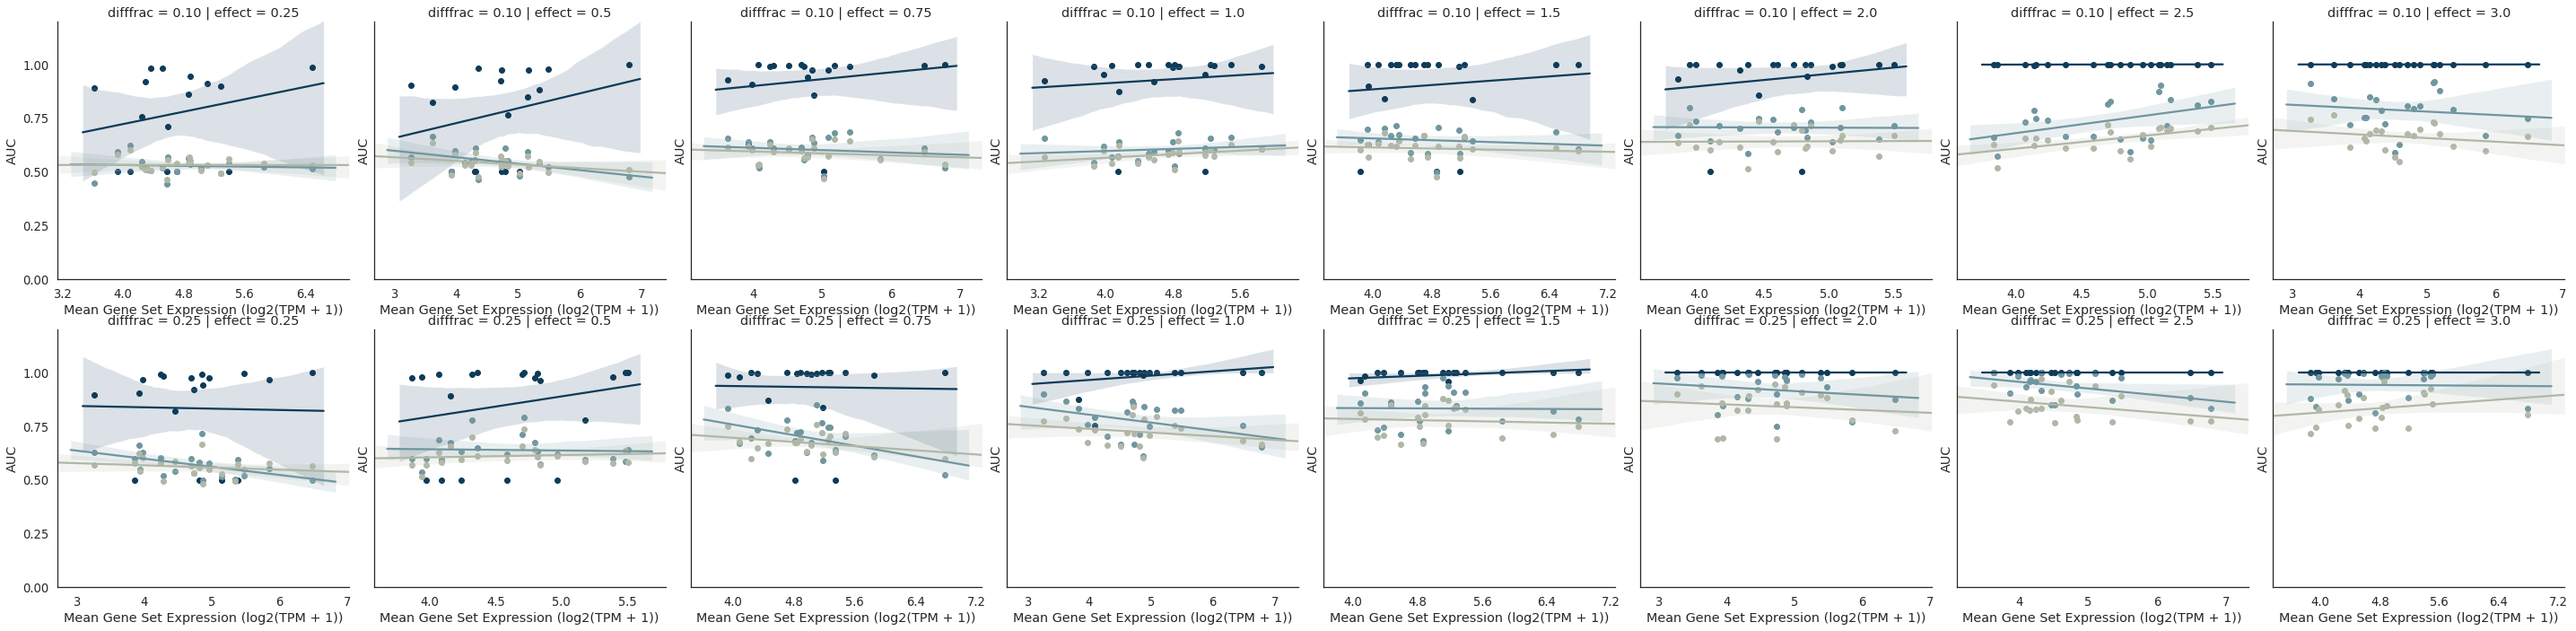

In [12]:
sns.set(style='white', font_scale=1.2)

g = sns.lmplot(x="gs_mean", 
               y='auc', 
               hue='method',
               row='difffrac',
               col='effect',
               data=plot_df,
               legend=False,
               palette=palette,
               scatter_kws={'alpha': 1.0},
               line_kws={'alpha': 1.0},
               sharex=False,
               sharey=True)

axes = g.axes

for row in axes:
    for ax in row:
        ax.set_ylim(0, 1.2)
        ax.set_xlabel('Mean Gene Set Expression (log2(TPM + 1))')
        ax.set_ylabel('AUC')

#g.ax.legend(title='Method', frameon=False, loc=(1.0, 0.4))

#pth = '/home/jpfeil/MEGAsync/Dropbox/hydra-paper/Figure2ROC/pan-hallmark-auc-vs-mean-plot-%s.svg' % date
#plt.savefig(pth, format='svg', bbox_inches='tight')

In [13]:
from scipy import stats

for i, rows in plot_df.groupby(['method', 'difffrac']):
    print(i)
    s, p = stats.pearsonr(rows['auc'], rows['gs_mean'])
    print(s, p)

('GSVA', '0.10')
(-0.040101287586283015, 0.6146331329691974)
('GSVA', '0.25')
(-0.04654766194067569, 0.5588927355497071)
('Hydra', '0.10')
(nan, 1.0)
('Hydra', '0.25')
(nan, 1.0)
('ssGSEA', '0.10')
(-0.06475939528157762, 0.4158853126602595)
('ssGSEA', '0.25')
(-0.11474372883190039, 0.14851336171695442)


In [14]:
plot_df.head()

,method,gene-set,auc,gs_mean,effect,difffrac
0,Hydra,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.999091,5.483513,0.5,0.25
1,ssGSEA,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.584739,5.483513,0.5,0.25
2,GSVA,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.637814,5.483513,0.5,0.25
3,Hydra,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.500000,4.090759,0.5,0.25
4,ssGSEA,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.594456,4.090759,0.5,0.25


In [15]:
plot_df.loc[pd.isna(plot_df['auc']), ['gene-set', 'effect', 'difffrac']]

,gene-set,effect,difffrac
273,HALLMARK_IL6_JAK_STAT3_SIGNALING,0.25,0.25
321,HALLMARK_IL2_STAT5_SIGNALING,0.50,0.10
348,HALLMARK_APICAL_SURFACE,0.50,0.10
459,HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY,0.25,0.10
642,HALLMARK_INTERFERON_ALPHA_RESPONSE,0.25,0.10
708,HALLMARK_HEDGEHOG_SIGNALING,0.25,0.10
792,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.25,0.10
873,HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY,0.75,0.10
942,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.75,0.10


In [16]:
lost_gs = plot_df.loc[pd.isna(plot_df['auc']), ['gene-set', 'effect', 'difffrac']]

for i, gs, eff, diff in lost_gs.itertuples():
    mask = (plot_df['gene-set'] == gs) & (plot_df['effect'] == eff) & (plot_df['difffrac'] == diff)
    plot_df = plot_df[~mask]

In [17]:
plot_df.loc[plot_df['difffrac'] == '0.10', '%DEG'] = '10%'
plot_df.loc[plot_df['difffrac'] == '0.25', '%DEG'] = '25%'

In [18]:
def mean_confidence_interval2(data, confidence=0.95):
    import scipy
    import numpy as np
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

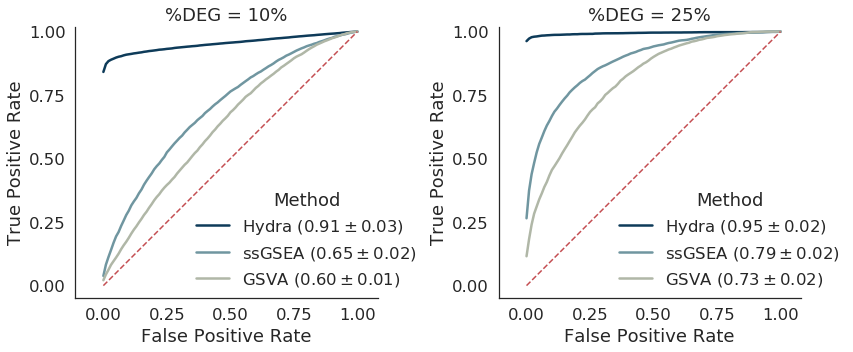

In [19]:
sns.set(style='white', font_scale=1.5)

# based on:
# https://stats.stackexchange.com/questions/186337/average-roc-for-repeated-10-fold-cross-validation-with-probability-estimates

fig, ax = plt.subplots(1, 2, figsize=(13, 5))

base_fpr = np.linspace(0, 1, 101)

diff_ind = {'0.10': 0, '0.25': 1}

for color, method, name in zip(palette,
                               ['hydra', 'ssgsea', 'gsva'],
                               ['Hydra', 'ssGSEA', 'GSVA']):

    for diff, l1 in datar[method].items():
        tprs = None
        for eff, l2 in l1.items():
            if float(eff) < 1.0:
                continue
            for gs, (fpr, tpr) in l2.items():
                mask = (plot_df['gene-set'] == gs) & (plot_df['effect'] == float(eff)) & (plot_df['difffrac'] == diff)
                if len(plot_df[mask]) == 0:
                    print('Skipping Lost Model', gs)
                    print(plot_df[mask])
                    continue
                
                #ax.plot(fpr, tpr, label=method)
                btpr = np.interp(base_fpr, fpr, tpr)
            
                if tprs is None:
                    tprs = btpr
            
                else:
                    tprs = np.vstack([btpr, tprs])
                    
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)
    
        ax[diff_ind[diff]].plot([0.] + base_fpr, 
                                [0.] + mean_tprs, 
                                color, 
                                label=name,
                                linewidth=2.5)

for i in [0, 1]:
    ax[i].plot([0, 1], [0, 1],'r--')
    ax[i].set_xlim([-0.05, 1.02])
    ax[i].set_ylim([-0.05, 1.02])

    ax[i].set_ylabel("True Positive Rate")
    ax[i].set_xlabel("False Positive Rate")
    ax[i].set_aspect("equal", 'datalim')
    

ax[0].set_title("%DEG = 10%")
ax[1].set_title("%DEG = 25%")

#plt.title('Mean ROC Curve for HALLMARK Gene Sets')

hy1, hy2 = mean_confidence_interval2(plot_df.loc[(plot_df['method'] == 'Hydra') & (plot_df['%DEG'] == '10%') , 'auc'])
ss1, ss2 = mean_confidence_interval2(plot_df.loc[(plot_df['method'] == 'ssGSEA') & (plot_df['%DEG'] == '10%'), 'auc'])
gs1, gs2 = mean_confidence_interval2(plot_df.loc[(plot_df['method'] == 'GSVA') & (plot_df['%DEG'] == '10%'), 'auc'])

L = ax[0].legend(title='Method', 
                 frameon=False,
                 bbox_to_anchor=(0.35, 0.45))

L.get_texts()[0].set_text("Hydra ($%.2f \pm %.2f$)" % (hy1, hy2))
L.get_texts()[1].set_text("ssGSEA ($%.2f \pm %.2f$)" % (ss1, ss2))
L.get_texts()[2].set_text("GSVA ($%.2f \pm %.2f$)" % (gs1, gs2))

hy1, hy2 = mean_confidence_interval2(plot_df.loc[(plot_df['method'] == 'Hydra') & (plot_df['%DEG'] == '25%') , 'auc'])
ss1, ss2 = mean_confidence_interval2(plot_df.loc[(plot_df['method'] == 'ssGSEA') & (plot_df['%DEG'] == '25%'), 'auc'])
gs1, gs2 = mean_confidence_interval2(plot_df.loc[(plot_df['method'] == 'GSVA') & (plot_df['%DEG'] == '25%'), 'auc'])

L = ax[1].legend(title='Method', 
                 frameon=False,
                 bbox_to_anchor=(0.35, 0.45))

L.get_texts()[0].set_text("Hydra ($%.2f \pm %.2f$)" % (hy1, hy2))
L.get_texts()[1].set_text("ssGSEA ($%.2f \pm %.2f$)" % (ss1, ss2))
L.get_texts()[2].set_text("GSVA ($%.2f \pm %.2f$)" % (gs1, gs2))

sns.despine()


plt.subplots_adjust(wspace=0.4)

pth = 'img/ROC-plot-per-diff.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = 'img/ROC-plot-per-diff.png'
plt.savefig(pth, format='png', bbox_inches='tight')

In [20]:
plot_df

,method,gene-set,auc,gs_mean,effect,difffrac,%DEG
0,Hydra,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.999091,5.483513,0.50,0.25,25%
1,ssGSEA,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.584739,5.483513,0.50,0.25,25%
2,GSVA,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.637814,5.483513,0.50,0.25,25%
3,Hydra,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.500000,4.090759,0.50,0.25,25%
4,ssGSEA,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.594456,4.090759,0.50,0.25,25%
5,GSVA,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.581069,4.090759,0.50,0.25,25%
6,Hydra,HALLMARK_MYC_TARGETS_V1,0.999928,6.787506,1.50,0.10,10%
7,ssGSEA,HALLMARK_MYC_TARGETS_V1,0.604938,6.787506,1.50,0.10,10%
8,GSVA,HALLMARK_MYC_TARGETS_V1,0.596130,6.787506,1.50,0.10,10%
9,Hydra,HALLMARK_KRAS_SIGNALING_DN,0.921827,3.269809,1.00,0.10,10%


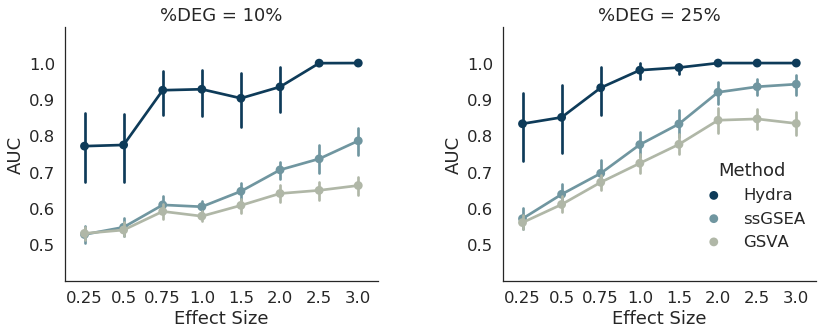

In [21]:
sns.set(style='white', font_scale=1.5)

g = sns.catplot(x='effect', 
                y='auc',
                hue='method',
                col='%DEG',
                col_order=['10%', '25%'],
                kind='point',
                data=plot_df,
                palette=palette,
                scatter_kws={'alpha': 1.0},
                line_kws={'alpha': 1.0},
                sharex=False,
                sharey=False,
                legend=False,
                aspect=1.2)

axes = g.axes

for row in axes:
    for ax in row:
        ax.set_ylim(0.4, 1.1)
        ax.set_xlabel('Effect Size')
        ax.set_ylabel('AUC')
        ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.subplots_adjust(wspace=0.4)

plt.legend(title='Method', frameon=False, loc=(0.6, 0.1))
        
pth = 'img/auc-vs-eff.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = 'img/auc-vs-eff.png'
plt.savefig(pth, format='png', bbox_inches='tight')